# Demo - RBIG

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML
%matplotlib inline

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

# %load_ext lab_black

# %load_ext autoreload
# %autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
from rbig_jax.data import SCurveDataset as PlaneDataset
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 1_000_000
n_features = 2
noise = 0.1
n_train = 5_000
n_valid = 1_000

ds = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)

data = ds[:]

In [4]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [5]:
X = jnp.array(data, dtype=np.float64)

## Model

In [6]:
from rbig_jax.models import RBIG

# a lot of parameters...
support_extension = 20
precision = 1_000
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = None
alpha = 1e-5
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 1_000
zero_tolerance = 60
p = 0.25
base = 2

# initialize the max layers parameters
verbose = True
n_layers_remove = 40
interval = 10

# everything (makes it fast...)
jitted = True

#### Training

In [7]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 2.063 - Elapsed Time: 5.2067 secs
Layer 20 - Cum. Info Reduction: 2.156 - Elapsed Time: 6.8024 secs
Layer 30 - Cum. Info Reduction: 2.370 - Elapsed Time: 8.3549 secs
Layer 40 - Cum. Info Reduction: 2.411 - Elapsed Time: 9.8340 secs
Layer 50 - Cum. Info Reduction: 2.455 - Elapsed Time: 11.3444 secs
Layer 60 - Cum. Info Reduction: 2.455 - Elapsed Time: 12.9009 secs
Layer 70 - Cum. Info Reduction: 2.500 - Elapsed Time: 14.4444 secs
Layer 80 - Cum. Info Reduction: 2.535 - Elapsed Time: 16.1020 secs
Layer 90 - Cum. Info Reduction: 2.568 - Elapsed Time: 18.6512 secs
Layer 100 - Cum. Info Reduction: 2.568 - Elapsed Time: 20.1270 secs
Layer 110 - Cum. Info Reduction: 2.602 - Elapsed Time: 21.7564 secs
Layer 120 - Cum. Info Reduction: 2.633 - Elapsed Time: 23.2975 secs
Layer 130 - Cum. Info Reduction: 2.657 - Elapsed Time: 24.9704 secs
Layer 140 - Cum. Info Reduction: 2.657 - Elapsed Time: 26.5537 secs
Layer 150 - Cum. Info Reduction: 2.689 - Elapsed Time: 28.050

### Gaussianized Data

#### Training Loop

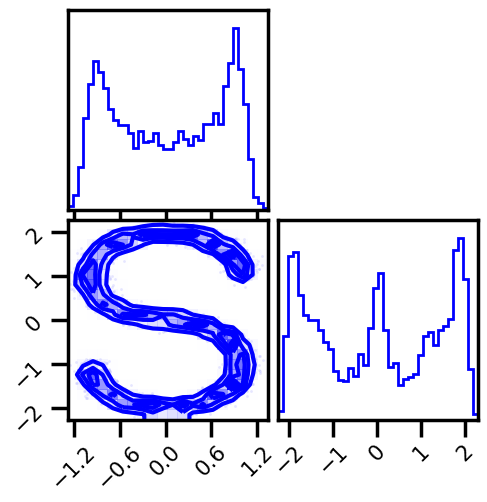

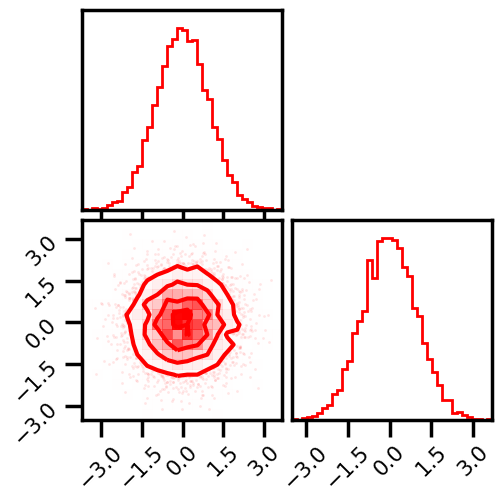

In [8]:
# plot data
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
plt.show()

#### From Model

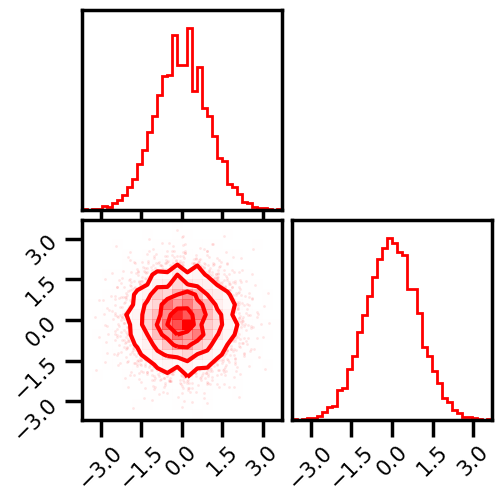

CPU times: user 21 s, sys: 1.11 s, total: 22.1 s
Wall time: 19.3 s


In [9]:
%%time
X_g_ = rbig_model.forward(X)

# plot data
fig = corner.corner(X_g_, color="red", hist_bin_factor=2)
plt.show()

#### Information Reduction Evolution

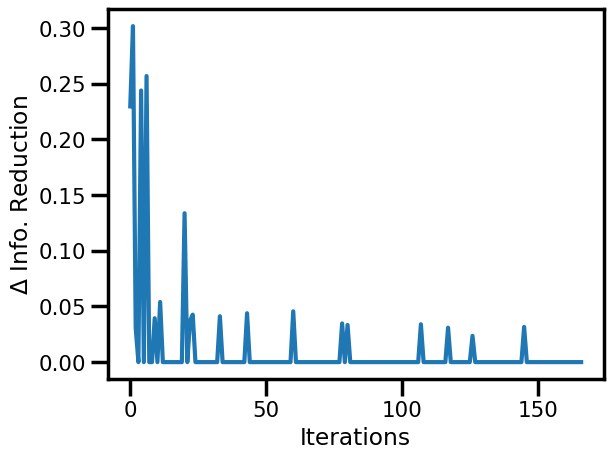

In [10]:
fig, ax = plt.subplots()
ax.plot(rbig_model.info_loss)
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [11]:
nll = rbig_model.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 1.5169


### Density Estimation

In [12]:
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

#### Generate Grid Points

In [14]:
# Original Density
from matplotlib import cm

n_samples = 1_000_000
n_features = 2
ds = PlaneDataset(n_samples=n_samples, seed=42)
X_plot = ds[:]
# X_plot = scaler.transform(X_plot)

#### Plot - Compare

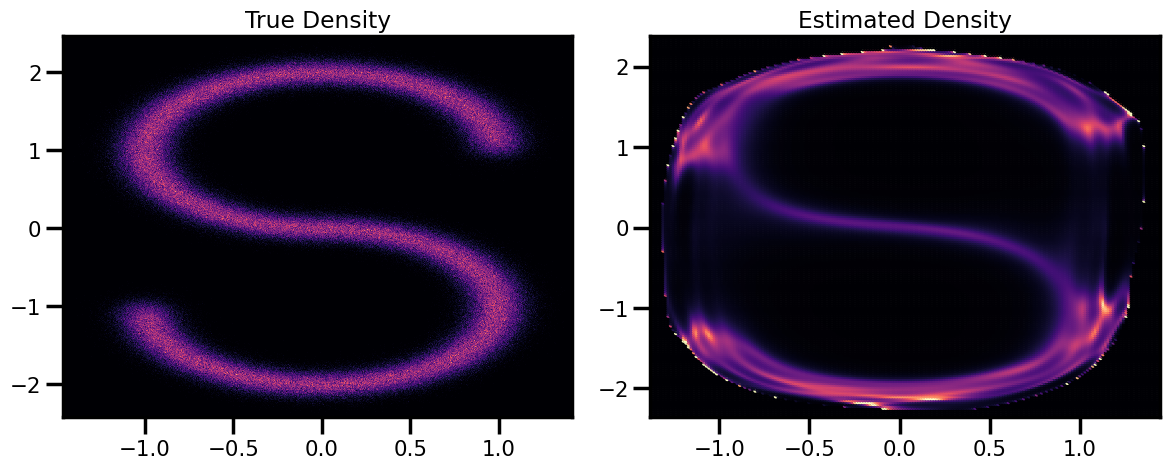

In [15]:
# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Sampling

In [16]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 35.8 s, sys: 1.72 s, total: 37.5 s
Wall time: 13.6 s


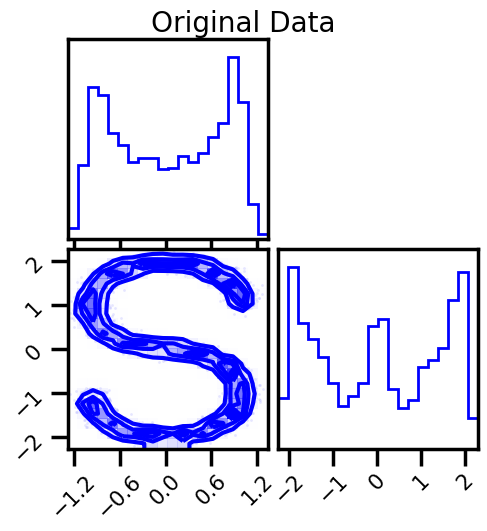

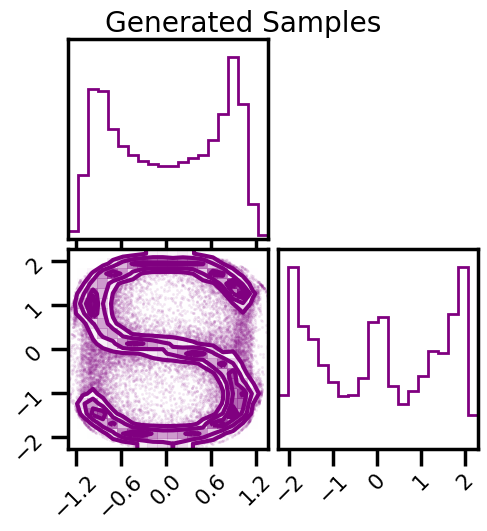

In [17]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [18]:
# import pickle

# # save the blocks
# with open("rbig_block.pickle", "wb") as f:
#     pickle.dump(rbig_block, f)

# save the bijectors
# with open("bijectors.pickle", "wb") as f:
#     pickle.dump(bijectors, f)

# # save the full model
# with open("rbig_model_test.pickle", "wb") as f:
#     pickle.dump(rbig_model, f)
import joblib  
joblib.dump(rbig_model, "rbig_model_test.pickle")

['rbig_model_test.pickle']

#### Loading

Loading is straight forward!

In [19]:
# with open("rbig_model.pickle", "rb") as f:
#     rbig_model_loaded = pickle.load(f)
    
rbig_model_loaded = joblib.load("rbig_model_test.pickle")

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [20]:
# nll for the old model
nll = rbig_model.score(X)

# nll for the loaded model
nll_loaded = rbig_model_loaded.score(X)

# check that they're the same
chex.assert_tree_all_close(nll, nll_loaded)
print(f"NLL (Original): {nll:.4f}")
print(f"NLL (Loaded): {nll_loaded:.4f}")

NLL (Original): 1.5169
NLL (Loaded): 1.5169
